In this project, I tackle forecasting the implied volatility of 3 large tech stocks using a GARCH model, determine the value of stock options for each company based on the Black-Scholes Merton formula, and compare my estimates with the option prices in the market.

##Downloading Historical Stock Return Data

In [104]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from arch.__future__ import reindexing

Forecasting GOOGL, AMZN, META Volatility

In [122]:
import pandas as pd
from datetime import datetime
import yfinance as yf

stocks = ['GOOGL', 'AMZN', 'MSFT']
start = datetime(2010, 1, 1)
end = datetime(2023, 5, 3)
stock_df = pd.DataFrame()

for stock in stocks:
    df = yf.download(stock, start=start, end=end)
    returns = 100 * df['Close'].pct_change().dropna()
    stock_df[stock] = returns

stock_df


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,GOOGL,AMZN,MSFT
Date,,,
2010-01-05,-0.440366,0.589989,0.032305
2010-01-06,-2.520872,-1.811563,-0.613691
2010-01-07,-2.327955,-1.701326,-1.039973
2010-01-08,1.333116,2.707694,0.689652
2010-01-11,-0.151158,-2.404135,-1.272014
...,...,...,...
2023-04-26,-0.134809,2.349618,7.243476
2023-04-27,3.741199,4.610398,3.202760
2023-04-28,-0.232364,-3.979241,0.797173


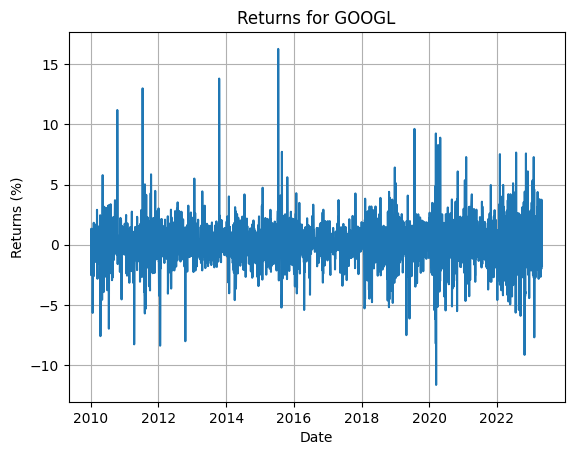

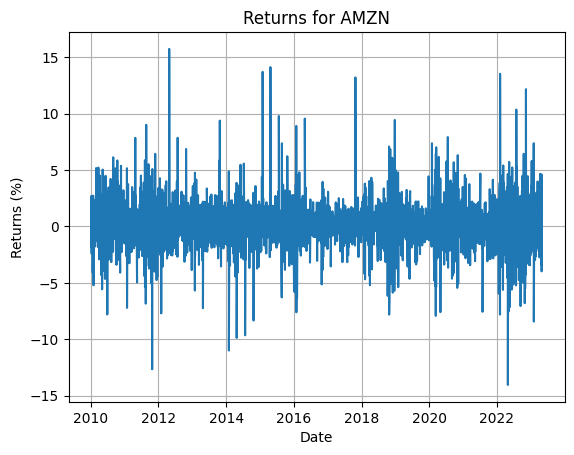

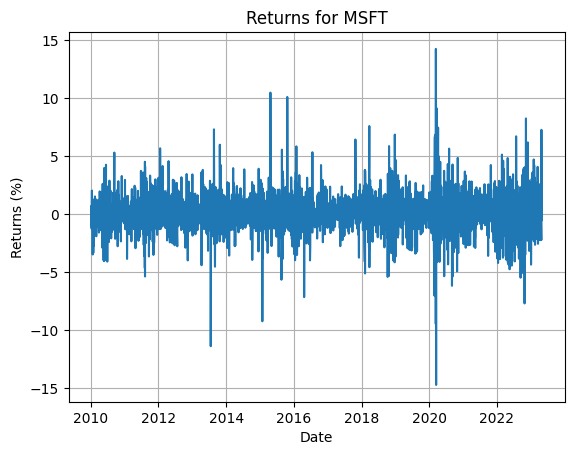

In [107]:
for stock in stocks:
    plt.figure()
    plt.plot(stock_df.index, stock_df[stock])
    plt.title(f'Returns for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.grid(True)

plt.show()

## PACF

The partial autocorrelation function (PACF) provides insights into the level of autocorrelation present in our data. By examining the PACF, we can assess the degree of autocorrelation and make informed decisions about the appropriate GARCH parameters to employ. In the case of our stocks, the PACF suggests a relatively low level of autocorrelation, thus supporting the reasonable assumption of using p=1 for the GARCH model.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

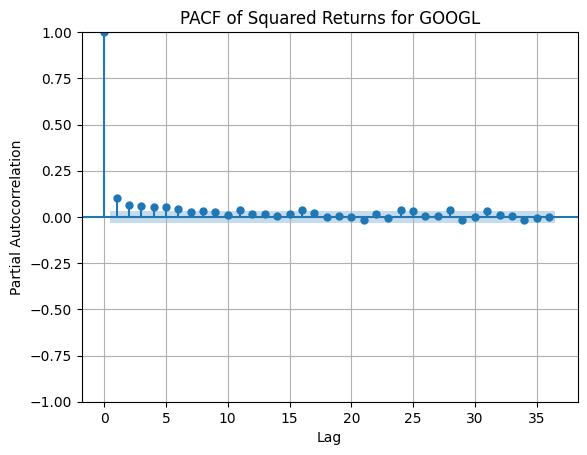

<Figure size 640x480 with 0 Axes>

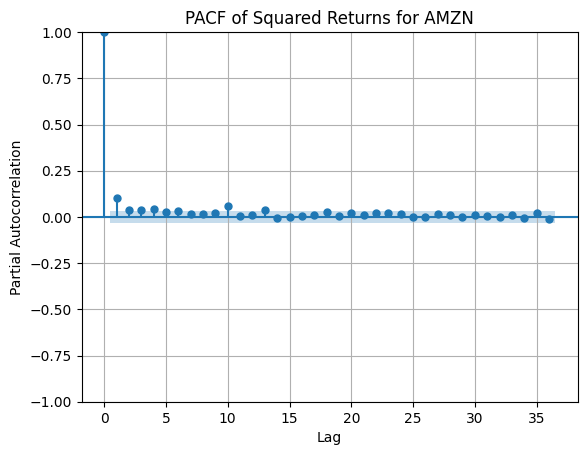

<Figure size 640x480 with 0 Axes>

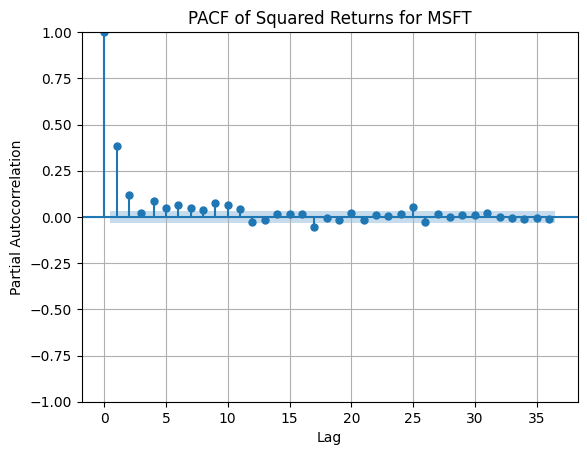

In [108]:
for stock in stocks:
    plt.figure()
    plot_pacf(stock_df[stock]**2)
    plt.title(f'PACF of Squared Returns for {stock}')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.grid(True)

plt.show()

##Training the GARCH Model

We will now proceed to make a rolling prediction using the GARCH model that we will fit for each stock. In the chart, we aim to visualize the relationship between volatility and returns, observing how volatility increases during periods of heightened return volatility. By incorporating this technical information, we can gain insights into the dynamics of the stock's behavior. Let's proceed with the analysis and evaluate the results!

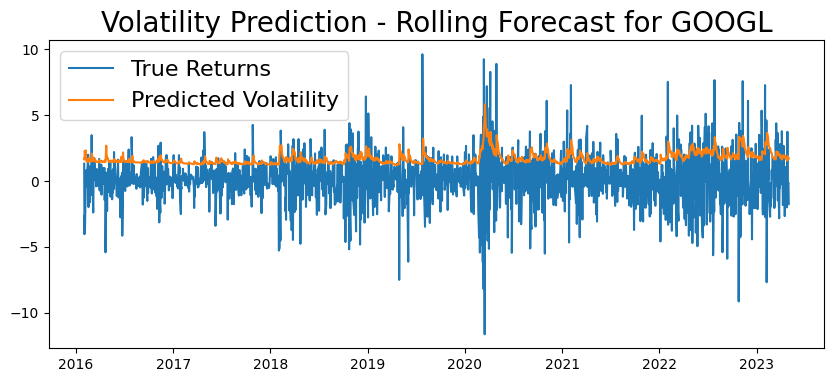

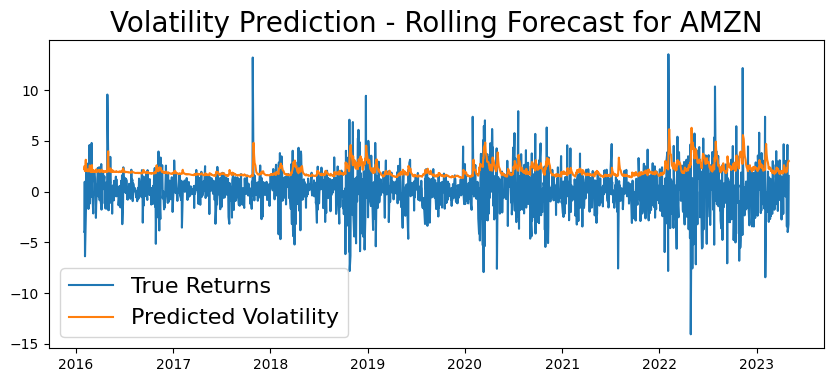

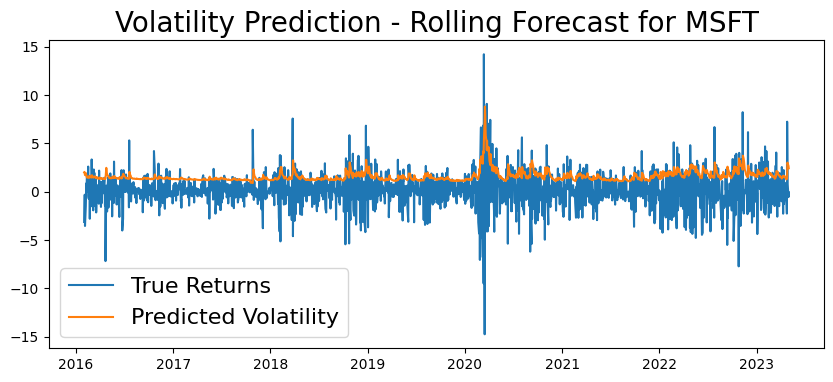

In [109]:
test_size = 365 * 5

for stock in stocks:
    rolling_predictions = []

    for i in range(test_size):
        train = stock_df[stock][:-(test_size - i)]
        model = arch_model(train, p=1, q=1)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1, :][0]))

    rolling_predictions = pd.Series(rolling_predictions, index=stock_df.index[-test_size:])
    plt.figure(figsize=(10, 4))
    true, = plt.plot(stock_df[stock].iloc[-test_size:])
    preds, = plt.plot(rolling_predictions)
    plt.title(f'Volatility Prediction - Rolling Forecast for {stock}', fontsize=20)
    plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)
    plt.show()

Not bad at all!

##Forecasting Volatility

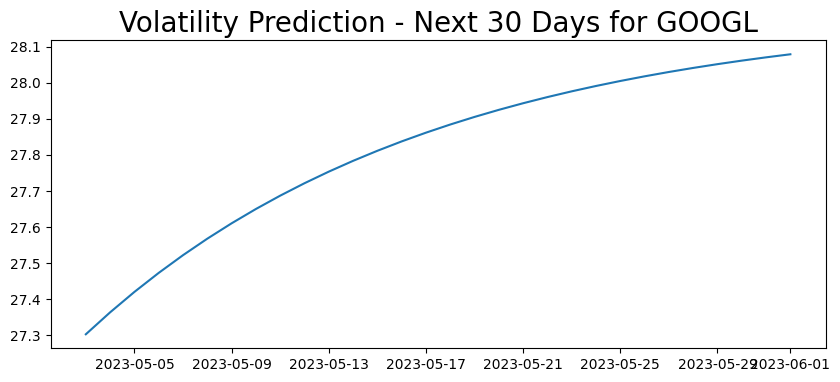

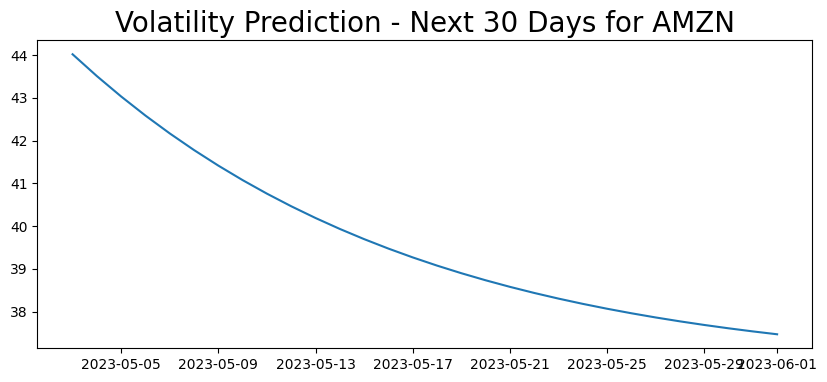

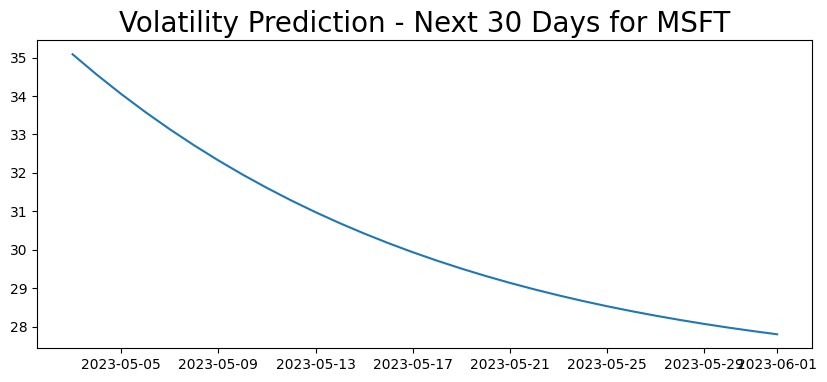

In [141]:
future_days = 30
trading_days = 252
vols = {}
for stock in stocks:
    model = arch_model(stock_df[stock], vol='Garch', p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=future_days)
    future_dates = [stock_df.index[-1] + timedelta(days=i) for i in range(1, future_days + 1)]
    pred_daily = pd.Series(np.sqrt(pred.variance.values[-1, :]), index=future_dates)

    # Convert daily volatility to annualized percentage volatility
    pred_annualized = pred_daily * np.sqrt(trading_days) 

    plt.figure(figsize=(10, 4))
    plt.plot(pred_annualized)
    plt.title(f'Volatility Prediction - Next {future_days} Days for {stock}', fontsize=20)
    vols[stock] = pred_annualized[-1]/100
plt.show()

Now we have our predicted volatilities for each stock, which means we can think about option values






##Visualizing and Predicting Option Values with Black Scholes

In the following code, we define a function named plot_black_scholes_option_values, which generates a 3D scatter plot of option values based on the Black-Scholes model. This function takes into account the stock ticker and its predicted volatility as input parameters. It also utilizes historical stock data from the yfinance library to determine suitable ranges for the underlying stock price, strike price, and volatility. Because our volatility prediction is 50 days out, we look at options that are expiring 50 days from now. The colors of the scatter plot represent the corresponding option values, providing a comprehensive visualization of the option value landscape.

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf
from mpl_toolkits.mplot3d import Axes3D

def plot_option_values(stock, pred_vol):
    start_date = '2023-05-01'
    end_date = '2023-05-07'

    # Get stock data from yfinance
    data = yf.download(stock, start=start_date, end=end_date)
    S_0 = data['Close'][-1]

    K_range = np.arange(0.5 * S_0, 2.1 * S_0, 0.05 * S_0)  # Range of strike prices to consider
    vol_range = np.linspace(pred_vol - 0.1, pred_vol + 0.1, 100)
    S_0_range = np.linspace(0.8 * S_0, 1.2 * S_0, 100)
    r = .06
    mu = 0
    sigma = 1
    T = 50/365

    c_matrix = np.zeros((len(K_range), len(vol_range), len(S_0_range)))

    # Loop over each value of K, S_0, and vol and calculate the option value
    for i in range(len(K_range)):
        K = K_range[i]
        for j in range(len(vol_range)):
            vol = vol_range[j]
            for k in range(len(S_0_range)):
                S_0 = S_0_range[k]
                d1 = (np.log(S_0 / K) + (r + vol ** 2 / 2) * T) / (vol * np.sqrt(T))
                d2 = d1 - (vol * np.sqrt(T))
                c = (S_0 * norm.cdf(d1, mu, sigma)) - (K * (np.e ** (-r * T)) * norm.cdf(d2, mu, sigma))
                c_matrix[i, j, k] = c

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Get the color map
    color_map = plt.cm.get_cmap("YlGnBu")

    # Normalize the color map based on the call option values
    norm_c = plt.Normalize(c_matrix.min(), c_matrix.max())

    x, y, z = np.meshgrid(K_range, vol_range, S_0_range, indexing='ij')

    # Plot the 3D scatter plot
    sc = ax.scatter(x, y, z, c=c_matrix.flatten(), cmap=color_map, marker='o', alpha=0.6, linewidth=0, s=20, norm=norm_c)

    ax.set_xlabel('Strike Price (K)')
    ax.set_ylabel('Volatility')
    ax.set_zlabel('Underlying Asset Price (S_0)')
    ax.set_title(f'Call Option Values for {stock}')

    # Add a colorbar with a label and more ticks
    cbar = fig.colorbar(sc, shrink=0.6, aspect=10, pad=0.1)
    cbar.ax.set_ylabel('Option Value')

    plt.show()


[*********************100%***********************]  1 of 1 completed


<ipython-input-142-dcb3a1e433d7>:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap("YlGnBu")


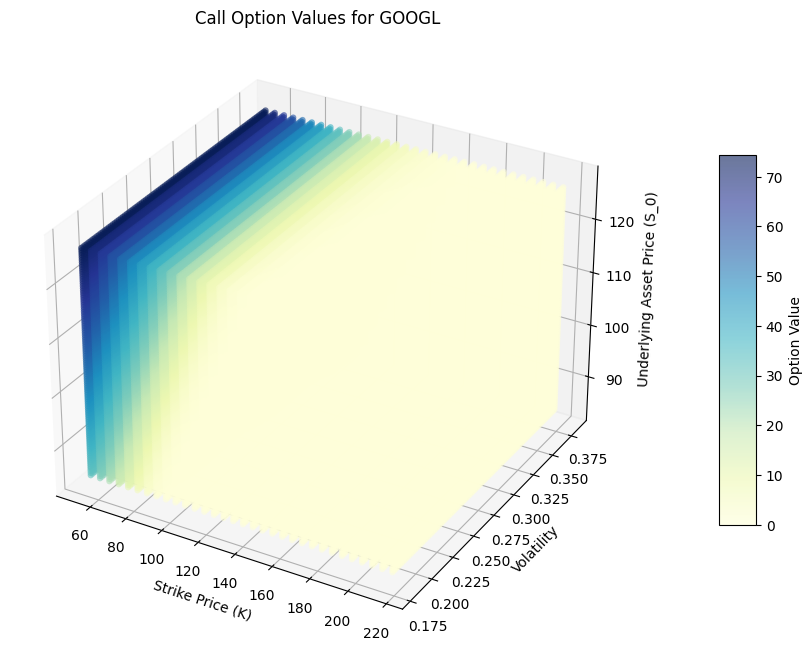

In [143]:
plot_option_values('GOOGL', vols['GOOGL'])

[*********************100%***********************]  1 of 1 completed


<ipython-input-142-dcb3a1e433d7>:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap("YlGnBu")


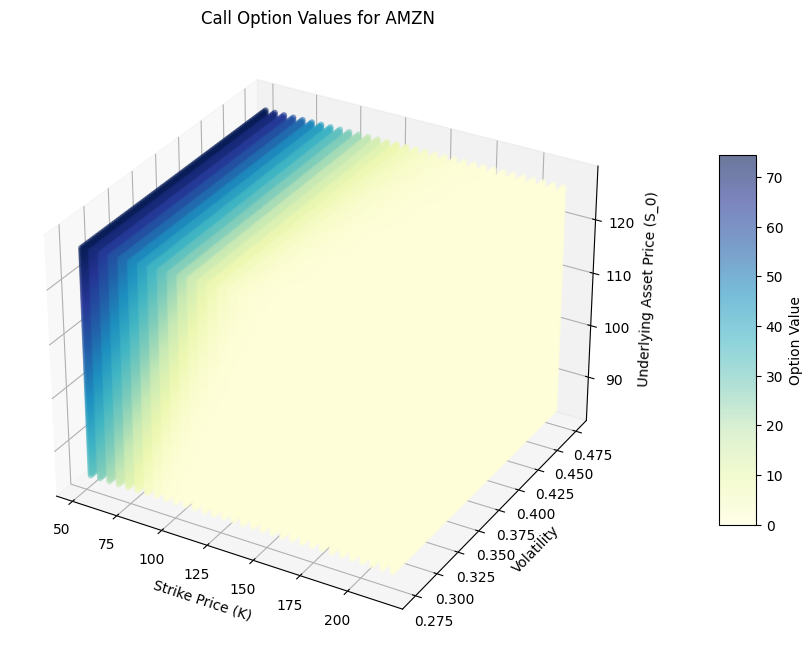

In [144]:
plot_option_values('AMZN', vols['AMZN'])

[*********************100%***********************]  1 of 1 completed


<ipython-input-142-dcb3a1e433d7>:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap("YlGnBu")


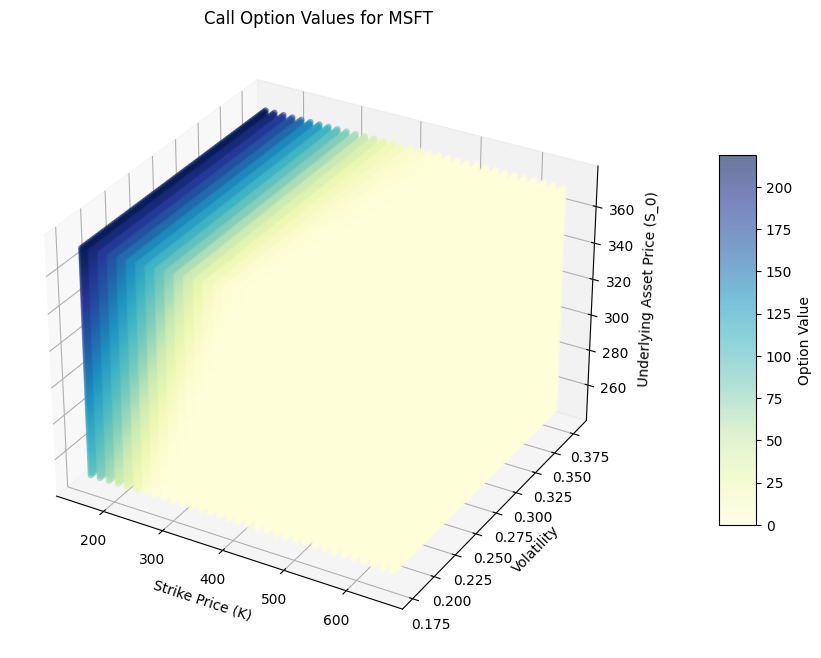

In [145]:
plot_option_values('MSFT', vols['MSFT'])

##Comparison with Options in Market

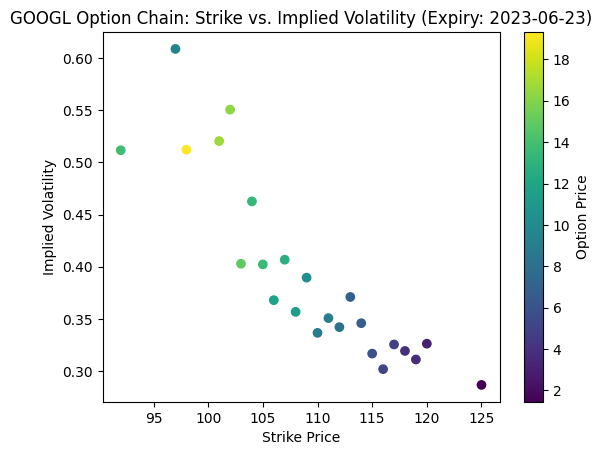

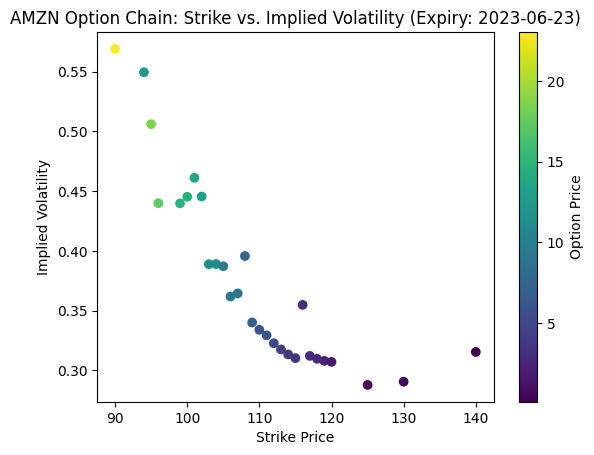

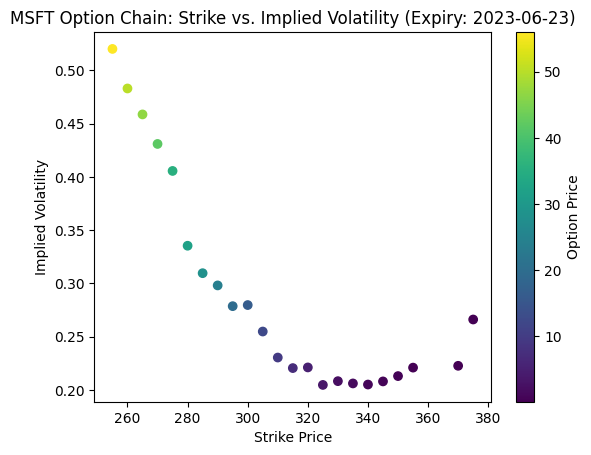

In [156]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt

def get_option_data_50_days(stock):
    # Retrieve the stock data using yfinance
    stock_data = yf.Ticker(stock)
    today = datetime.date.today()
    target_date = today + datetime.timedelta(days=50)

    # Find the option expiration closest to 50 days
    expirations = stock_data.options
    closest_date = min(expirations, key=lambda x: abs(datetime.datetime.strptime(x, "%Y-%m-%d").date() - target_date))

    # Get the option chain for the closest expiration
    option_chain = stock_data.option_chain(closest_date)
    calls = pd.DataFrame(option_chain.calls)

    # Create a scatterplot of strike price vs. implied volatility, with color mapping for option prices
    fig, ax = plt.subplots()
    scatter = ax.scatter(calls['strike'], calls['impliedVolatility'], c=calls['lastPrice'], cmap='viridis')
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.title(f'{stock} Option Chain: Strike vs. Implied Volatility (Expiry: {closest_date})')

    # Add a colorbar to the plot
    cbar = plt.colorbar(scatter)
    cbar.ax.set_ylabel('Option Price')

    plt.show()

# Call the function for each stock
stocks = ['GOOGL', 'AMZN', 'MSFT']
for stock in stocks:
    get_option_data_50_days(stock)



Comparing with our computed option prices, we see some clear discrepancies from our projections and the real world. GOOGL for example, is trading at a much higher value that we expect for strikes around the $90 range. Perhaps there is an issue with our calculation, or perhaps we have identified a mispriced option. From here, we could attempt to backtest this strategy on more data, use more quantitative metrics, and develop a strategy based on our findings.